# Robot Q-Learning, segunda aprox

## Importamos todos los paquetes necesarios

In [10]:
import numpy as np
import pandas as pd
import random
import yfinance as yf
from tqdm import tqdm
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## Definimos todas las funciones para el preproceso de datos

In [2]:
# Descarga del ticker
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = stock_data.dropna()
    return stock_data

# Cálculo ratio de media móvil y ancho ponderado de las bandas de bollinger (1std)
def get_smaratio_bandwidth(values, window):
    sma = values.rolling(window = window).mean()
    mstd = values.rolling(window = window).std()
    
    band_width = 2 * mstd / sma
    smaratio = values / sma
    return smaratio, band_width

# Obtenemos el ratio de media móvil a largo plazo
def get_smaratio_lt(values, window_lt):
    sma_lt = values.rolling(window = window_lt).mean()
    lt_ratio_values = values / sma_lt
    return lt_ratio_values

# Creamos dataframe general, datos descargados + calculos anteriores
def create_dataframe(stock_data, window, window_lt):
    values = stock_data["Adj Close"]
    stock_data["sma_ratio"], stock_data["BB_Width"] = get_smaratio_bandwidth(values, window)
    stock_data["Adj_Close_lt"] = get_smaratio_lt(values, window_lt)
    return stock_data
    

# Discretizamos (calculamos los rangos para las variables, que definirán los estados), creamos estructura estados
def discretize(values, num_states=10):
    states_value = dict()
    step_size = 1 / num_states
    for i in range(num_states):
        if i == num_states - 1:
            states_value[i] = values.max()
        else:
            states_value[i] = values.quantile((i+1) * step_size)
    return states_value


# Calculamos estado específico de cada entrada temporal
def generate_states(df, num_states = 10, train = True, states_smaratio = 0, states_bbwidth = 0, states_adjclose = 0):
    if train:
        states_smaratio = pd.Series(discretize(df["sma_ratio"], num_states))
        states_bbwidth = pd.Series(discretize(df["BB_Width"], num_states))
        states_adjclose = pd.Series(discretize(df["Adj_Close_lt"], num_states))
    
    df["state_sma_ratio"] =  df["sma_ratio"].apply(lambda x: np.min(states_smaratio[states_smaratio > x].index)).fillna(9)
    df["state_BB_Width"] =  df["BB_Width"].apply(lambda x: np.min(states_bbwidth[states_bbwidth > x].index)).fillna(9)
    df["state_Adj_Close"] =  df["Adj_Close_lt"].apply(lambda x: np.min(states_adjclose[states_adjclose > x].index)).fillna(9)
    
    df = df.dropna()
    
    df["state"] = df["state_sma_ratio"].astype(int).astype(str) + df["state_BB_Width"].astype(int).astype(str) + df["state_Adj_Close"].astype(int).astype(str)
    return df, states_smaratio, states_bbwidth, states_adjclose
    
    

## Definimos funciones para el trading

In [3]:
# Parámetros para el algoritmo de Q-Learning
GAMMA = 0.99 # Factor de descuento de recompensas futuras
EPSILON = 1.0 # Para tomar acciones aleatorias (e-greedy)
EPSILON_DECAY = 0.
EPSILON_MIN = 0.3
ALPHA = 0.1  # Learning Rate

class QLearningAgent:
    def __init__(self, gamma=GAMMA, epsilon=EPSILON, epsilon_decay=EPSILON_DECAY, epsilon_min=EPSILON_MIN, alpha=ALPHA):
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha = alpha
        self.q_table = pd.DataFrame()
    
    # Creamos la matriz q con indices del 000 al 999 y acciones 0, 1, 2
    def create_q_table(self):
        rows = [str(i).zfill(3) for i in range(1000)]
        self.q_table = pd.DataFrame(index = rows, columns=[0, 1, 2]).fillna(0.)
        return
    
    # Seleccionamos una accion (comprar, vender o mantener)
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(len(self.q_table.columns))
        q_values = self.q_table.loc[state]
        return np.argmax(q_values)
    
    # Actualizamos la matriz Q
    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table.loc[state][action]
        next_max = np.max(self.q_table.loc[next_state])

        # Actualizar la matriz Q usando la ecuacion de Bellman para actualizar los valores
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
        self.q_table.loc[state][action] = new_value
        return

    # Reducimos el epsilon (menos aleatoriedad en la toma de decisiones) Se mantendrá constante en 0.3
    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon, self.epsilon_min)
        return

def train_agent(ticker, initial_cash, initial_stock, n_episodes, df):
    print(f"Entrenando para {ticker}...\n")
    agent = QLearningAgent()
    agent.create_q_table()
    
    cash_initial = initial_cash
    stock_initial = initial_stock
    current_capital = initial_cash

    for e in tqdm(range(n_episodes)):
        cash = cash_initial
        stock = stock_initial
        capitals = []

        for t in range(len(df) - 1):
            state = df.iloc[t]["state"]
            action = agent.act(state)
            next_state = df.iloc[t + 1]["state"]
            actual_price = df.iloc[t]["Adj Close"]

            if action == 1:  # Comprar
                if stock < 0:
                    stock_to_buy = - stock
                    cash -= stock_to_buy * actual_price
                    stock += stock_to_buy
                    
                elif stock > 0:
                    pass
                
                elif stock == 0:
                    stock_to_buy = cash / actual_price
                    cash -= stock_to_buy * actual_price
                    stock += stock_to_buy
                    
            elif action == 2:  # Vender en corto
                if stock > 0:
                    stock_to_sell = stock
                    cash += stock_to_sell * actual_price
                    stock -= stock_to_sell
                    
                elif stock < 0:
                    pass
                
                elif stock == 0:
                    stock_to_sell = cash / actual_price
                    cash += stock_to_sell * actual_price
                    stock -= stock_to_sell
                    
            # Calcular la recompensa y actualizar la tabla Q
            future_capital = cash + stock * df.iloc[t + 1]["Adj Close"]
            base = (100 * ((future_capital - current_capital) / np.abs(current_capital)))
            
            if base < 0:
                reward = - ((- base) ** 1.5)
            else:
                reward = base ** 1.5
            
            #print("previous_capital", previous_capital, "\n",
            #     "current_capital", current_capital, "\n",
            #     "reward", reward, "\n",
            #     "action", action, "\n",
            #     "stock", stock, "\n",
            #     "cash", cash, "\n")
            
            current_capital = future_capital
            
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            capitals.append(current_capital)

        agent.decay_epsilon()

    return agent, current_capital, capitals


def test_agent(agent, ticker, initial_cash, initial_stock, df):
    cash = initial_cash
    stock = initial_stock
    current_capital = initial_cash
    agent.epsilon = 0
    agent.epsilon_decay = 0
    agent.epsilon_min = 0
    trading_history = pd.DataFrame({"Cash": [], "Stock money": [], "Capital" : []})
    
    for t in range(len(df) - 1):
        state = df.iloc[t]["state"]
        action = agent.act(state)
        actual_price = df.iloc[t]["Adj Close"]

        if action == 1:  # Comprar
            if stock < 0:
                stock_to_buy = - stock
                cash -= stock_to_buy * actual_price
                stock += stock_to_buy

            elif stock > 0:
                pass

            elif stock == 0:
                stock_to_buy = cash / actual_price
                cash -= stock_to_buy * actual_price
                stock += stock_to_buy

        elif action == 2:  # Vender en corto
            if stock > 0:
                stock_to_sell = stock
                cash += stock_to_sell * actual_price
                stock -= stock_to_sell

            elif stock < 0:
                pass

            elif stock == 0:
                stock_to_sell = cash / actual_price
                cash += stock_to_sell * actual_price
                stock -= stock_to_sell
        
        current_capital = cash + stock * actual_price
        trading_history.at[df.iloc[t].name, "Cash"] = cash
        trading_history.at[df.iloc[t].name, "Stock money"] = stock * actual_price
        trading_history.at[df.iloc[t].name, "Capital"]= current_capital   
        
    return agent, current_capital, trading_history

    

def train_test_agent(ticker, initial_cash, initial_stock, n_episodes,
                     start_date_train, end_date_train, start_date_test, end_date_test,
                     window = 3, window_lt = 252):
    
    stock_data_train = get_stock_data(ticker, start_date_train, end_date_train)
    df_train, states_smaratio, states_bbwidth, states_adjclose = generate_states(create_dataframe(stock_data_train, window = window, window_lt = window_lt))
    agent, current_capital, capitals = train_agent(ticker, initial_cash, initial_stock, n_episodes, df_train)
    
    stock_data_test = get_stock_data(ticker, start_date_test - timedelta(days = 252), end_date_test)
    df_test, _, _, _ = generate_states(create_dataframe(stock_data_test, window = window, window_lt = window_lt),
                                       train = False, states_smaratio = states_smaratio, 
                                       states_bbwidth = states_bbwidth, states_adjclose = states_adjclose)
    agent, current_capital, trading_history = test_agent(agent, ticker, initial_cash, initial_stock, df_test)
    return current_capital, trading_history
    

## Entrenamos y probamos el robot con múltiples acciones

### Cuidado con ejecutar la siguiente celda, tarda 6 horas aprox.

In [8]:
# Definimos las fechas que usaremos para entrenar y predecir
start_date_train = datetime(2012,1,1)
end_date_train = datetime(2017,1,1)
start_date_test = datetime(2017,1,1)
end_date_test = datetime(2022,10,30)

# Usaremos solamente las empresas que han tenido datos en el periodo de 2012 hasta octubre del 2022
check_dates_df = pd.read_csv("/Users/davidserrano/Documents/ICADE/5o ADE+ Analytics/TFG_Analytics/Datos/tabla_precios_final.csv")
check_dates_df['Date'] = pd.to_datetime(check_dates_df['Date'])
check_dates_df = check_dates_df[check_dates_df['Date'] > datetime(2012,1,1)]
df_no_nan = check_dates_df.dropna(axis=1)
STOCK_TICKERS = df_no_nan.columns.tolist()[1:] # Devuelve una lista con los nombres de las columnas restantes
nlok_index = STOCK_TICKERS.index("NLOK") # Cambio de nombre de NLOK a GEN
STOCK_TICKERS[nlok_index] = "GEN" 
STOCK_TICKERS.remove("SIVB") # Da error con la API de Yahoo Finance por su quiebra (Sillicon Valley Bank)

pd.options.mode.chained_assignment = None  # default='warn'

# Simulamos para cada una de los tickets
initial_capital = 10000000
cap_per_stock = 10000000 / len(STOCK_TICKERS)
general_hist = {}
for ticker in STOCK_TICKERS:
    final_cap, hist = train_test_agent(ticker = ticker, initial_cash = cap_per_stock, initial_stock = 0, n_episodes = 100,
                            start_date_train = datetime(2012,1,1), end_date_train = datetime(2017,1,1), 
                            start_date_test = datetime(2017,1,1), end_date_test = datetime(2022,10,30),
                            window = 3, window_lt = 252)
    general_hist[ticker] = hist
    print(f"Ticker: {ticker}\nRentabilidad: {round((final_cap / cap_per_stock - 1) * 100, 2)}%\n")

pd.options.mode.chained_assignment = "warn"  # default='warn'


[*********************100%***********************]  1 of 1 completed
Entrenando para A...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: A
Rentabilidad: 34.8%

[*********************100%***********************]  1 of 1 completed
Entrenando para AAL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AAL
Rentabilidad: 70.53%

[*********************100%***********************]  1 of 1 completed
Entrenando para AAP...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AAP
Rentabilidad: -56.92%

[*********************100%***********************]  1 of 1 completed
Entrenando para AAPL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AAPL
Rentabilidad: 177.92%

[*********************100%***********************]  1 of 1 completed
Entrenando para ABC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ABC
Rentabilidad: -51.67%

[*********************100%***********************]  1 of 1 completed
Entrenando para ABMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ABMD
Rentabilidad: -13.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para ABT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ABT
Rentabilidad: 20.03%

[*********************100%***********************]  1 of 1 completed
Entrenando para ACN...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ACN
Rentabilidad: -20.5%

[*********************100%***********************]  1 of 1 completed
Entrenando para ADBE...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ADBE
Rentabilidad: 578.71%

[*********************100%***********************]  1 of 1 completed
Entrenando para ADI...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ADI
Rentabilidad: 25.85%

[*********************100%***********************]  1 of 1 completed
Entrenando para ADM...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ADM
Rentabilidad: 8.1%

[*********************100%***********************]  1 of 1 completed
Entrenando para ADP...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ADP
Rentabilidad: 5.85%

[*********************100%***********************]  1 of 1 completed
Entrenando para ADSK...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ADSK
Rentabilidad: 177.26%

[*********************100%***********************]  1 of 1 completed
Entrenando para AEE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AEE
Rentabilidad: 10.5%

[*********************100%***********************]  1 of 1 completed
Entrenando para AEP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AEP
Rentabilidad: 148.01%

[*********************100%***********************]  1 of 1 completed
Entrenando para AES...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AES
Rentabilidad: 125.95%

[*********************100%***********************]  1 of 1 completed
Entrenando para AFL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AFL
Rentabilidad: -42.13%

[*********************100%***********************]  1 of 1 completed
Entrenando para AIG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AIG
Rentabilidad: -66.76%

[*********************100%***********************]  1 of 1 completed
Entrenando para AIZ...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AIZ
Rentabilidad: 138.13%

[*********************100%***********************]  1 of 1 completed
Entrenando para AJG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AJG
Rentabilidad: 41.28%

[*********************100%***********************]  1 of 1 completed
Entrenando para AKAM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AKAM
Rentabilidad: -39.5%

[*********************100%***********************]  1 of 1 completed
Entrenando para ALB...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ALB
Rentabilidad: 99.48%

[*********************100%***********************]  1 of 1 completed
Entrenando para ALGN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ALGN
Rentabilidad: -55.21%

[*********************100%***********************]  1 of 1 completed
Entrenando para ALK...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ALK
Rentabilidad: -59.23%

[*********************100%***********************]  1 of 1 completed
Entrenando para ALL...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ALL
Rentabilidad: -50.31%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMAT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMAT
Rentabilidad: -32.49%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 727.76%

[*********************100%***********************]  1 of 1 completed
Entrenando para AME...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AME
Rentabilidad: 10.56%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMGN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMGN
Rentabilidad: -32.56%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMP
Rentabilidad: 179.12%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMT
Rentabilidad: 48.1%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMZN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMZN
Rentabilidad: 64.29%

[*********************100%***********************]  1 of 1 completed
Entrenando para ANSS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ANSS
Rentabilidad: -82.67%

[*********************100%***********************]  1 of 1 completed
Entrenando para AON...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AON
Rentabilidad: 52.08%

[*********************100%***********************]  1 of 1 completed
Entrenando para AOS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AOS
Rentabilidad: -41.76%

[*********************100%***********************]  1 of 1 completed
Entrenando para APA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: APA
Rentabilidad: -27.81%

[*********************100%***********************]  1 of 1 completed
Entrenando para APD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: APD
Rentabilidad: -25.83%

[*********************100%***********************]  1 of 1 completed
Entrenando para APH...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: APH
Rentabilidad: 43.72%

[*********************100%***********************]  1 of 1 completed
Entrenando para APTV...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: APTV
Rentabilidad: 60.68%

[*********************100%***********************]  1 of 1 completed
Entrenando para ARE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ARE
Rentabilidad: 11.77%

[*********************100%***********************]  1 of 1 completed
Entrenando para ATO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ATO
Rentabilidad: 37.42%

[*********************100%***********************]  1 of 1 completed
Entrenando para ATVI...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ATVI
Rentabilidad: 67.86%

[*********************100%***********************]  1 of 1 completed
Entrenando para AVB...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AVB
Rentabilidad: 4.17%

[*********************100%***********************]  1 of 1 completed
Entrenando para AVGO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AVGO
Rentabilidad: 16.76%

[*********************100%***********************]  1 of 1 completed
Entrenando para AVY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AVY
Rentabilidad: 50.76%

[*********************100%***********************]  1 of 1 completed
Entrenando para AWK...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AWK
Rentabilidad: 45.43%

[*********************100%***********************]  1 of 1 completed
Entrenando para AXP...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AXP
Rentabilidad: 32.86%

[*********************100%***********************]  1 of 1 completed
Entrenando para AZO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AZO
Rentabilidad: 13.85%

[*********************100%***********************]  1 of 1 completed
Entrenando para BA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BA
Rentabilidad: -76.81%

[*********************100%***********************]  1 of 1 completed
Entrenando para BAC...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BAC
Rentabilidad: 22.57%

[*********************100%***********************]  1 of 1 completed
Entrenando para BALL...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BALL
Rentabilidad: 23.76%

[*********************100%***********************]  1 of 1 completed
Entrenando para BAX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BAX
Rentabilidad: -55.07%

[*********************100%***********************]  1 of 1 completed
Entrenando para BBWI...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BBWI
Rentabilidad: -75.56%

[*********************100%***********************]  1 of 1 completed
Entrenando para BBY...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BBY
Rentabilidad: -56.6%

[*********************100%***********************]  1 of 1 completed
Entrenando para BDX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BDX
Rentabilidad: -69.24%

[*********************100%***********************]  1 of 1 completed
Entrenando para BEN...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BEN
Rentabilidad: -65.06%

[*********************100%***********************]  1 of 1 completed
Entrenando para BF-B...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BF-B
Rentabilidad: -5.9%

[*********************100%***********************]  1 of 1 completed
Entrenando para BIIB...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: BIIB
Rentabilidad: -29.52%

[*********************100%***********************]  1 of 1 completed
Entrenando para BIO...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: BIO
Rentabilidad: -63.23%

[*********************100%***********************]  1 of 1 completed
Entrenando para BK...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BK
Rentabilidad: -21.96%

[*********************100%***********************]  1 of 1 completed
Entrenando para BKNG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: BKNG
Rentabilidad: -48.82%

[*********************100%***********************]  1 of 1 completed
Entrenando para BKR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BKR
Rentabilidad: 234.1%

[*********************100%***********************]  1 of 1 completed
Entrenando para BLK...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BLK
Rentabilidad: 5.61%

[*********************100%***********************]  1 of 1 completed
Entrenando para BMY...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BMY
Rentabilidad: 62.59%

[*********************100%***********************]  1 of 1 completed
Entrenando para BR...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BR
Rentabilidad: -18.31%

[*********************100%***********************]  1 of 1 completed
Entrenando para BRK-B...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: BRK-B
Rentabilidad: 66.51%

[*********************100%***********************]  1 of 1 completed
Entrenando para BRO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BRO
Rentabilidad: 148.6%

[*********************100%***********************]  1 of 1 completed
Entrenando para BSX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: BSX
Rentabilidad: 13.24%

[*********************100%***********************]  1 of 1 completed
Entrenando para BWA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BWA
Rentabilidad: 18.02%

[*********************100%***********************]  1 of 1 completed
Entrenando para BXP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: BXP
Rentabilidad: -16.38%

[*********************100%***********************]  1 of 1 completed
Entrenando para C...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: C
Rentabilidad: -11.66%

[*********************100%***********************]  1 of 1 completed
Entrenando para CAG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CAG
Rentabilidad: -45.29%

[*********************100%***********************]  1 of 1 completed
Entrenando para CAH...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CAH
Rentabilidad: 71.06%

[*********************100%***********************]  1 of 1 completed
Entrenando para CAT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CAT
Rentabilidad: -40.4%

[*********************100%***********************]  1 of 1 completed
Entrenando para CB...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CB
Rentabilidad: -48.99%

[*********************100%***********************]  1 of 1 completed
Entrenando para CBOE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CBOE
Rentabilidad: 14.06%

[*********************100%***********************]  1 of 1 completed
Entrenando para CBRE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CBRE
Rentabilidad: 99.5%

[*********************100%***********************]  1 of 1 completed
Entrenando para CCI...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CCI
Rentabilidad: 47.38%

[*********************100%***********************]  1 of 1 completed
Entrenando para CCL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CCL
Rentabilidad: -77.0%

[*********************100%***********************]  1 of 1 completed
Entrenando para CDNS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CDNS
Rentabilidad: -70.67%

[*********************100%***********************]  1 of 1 completed
Entrenando para CE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CE
Rentabilidad: -0.43%

[*********************100%***********************]  1 of 1 completed
Entrenando para CF...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CF
Rentabilidad: -60.14%

[*********************100%***********************]  1 of 1 completed
Entrenando para CHD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CHD
Rentabilidad: -6.68%

[*********************100%***********************]  1 of 1 completed
Entrenando para CHRW...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CHRW
Rentabilidad: 70.55%

[*********************100%***********************]  1 of 1 completed
Entrenando para CHTR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CHTR
Rentabilidad: -60.78%

[*********************100%***********************]  1 of 1 completed
Entrenando para CI...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CI
Rentabilidad: 59.02%

[*********************100%***********************]  1 of 1 completed
Entrenando para CINF...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CINF
Rentabilidad: -32.9%

[*********************100%***********************]  1 of 1 completed
Entrenando para CL...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CL
Rentabilidad: 30.78%

[*********************100%***********************]  1 of 1 completed
Entrenando para CLX...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CLX
Rentabilidad: -49.71%

[*********************100%***********************]  1 of 1 completed
Entrenando para CMA...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CMA
Rentabilidad: -1.46%

[*********************100%***********************]  1 of 1 completed
Entrenando para CMCSA...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CMCSA
Rentabilidad: 32.78%

[*********************100%***********************]  1 of 1 completed
Entrenando para CME...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CME
Rentabilidad: 0.3%

[*********************100%***********************]  1 of 1 completed
Entrenando para CMG...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CMG
Rentabilidad: 121.72%

[*********************100%***********************]  1 of 1 completed
Entrenando para CMI...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CMI
Rentabilidad: -29.14%

[*********************100%***********************]  1 of 1 completed
Entrenando para CMS...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CMS
Rentabilidad: -21.33%

[*********************100%***********************]  1 of 1 completed
Entrenando para CNC...



100%|█████████████████████████████████████████| 100/100 [00:45<00:00,  2.22it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CNC
Rentabilidad: -62.06%

[*********************100%***********************]  1 of 1 completed
Entrenando para CNP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CNP
Rentabilidad: 36.3%

[*********************100%***********************]  1 of 1 completed
Entrenando para COF...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: COF
Rentabilidad: -1.24%

[*********************100%***********************]  1 of 1 completed
Entrenando para COO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: COO
Rentabilidad: -29.33%

[*********************100%***********************]  1 of 1 completed
Entrenando para COP...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: COP
Rentabilidad: -65.36%

[*********************100%***********************]  1 of 1 completed
Entrenando para COST...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: COST
Rentabilidad: -7.39%

[*********************100%***********************]  1 of 1 completed
Entrenando para CPB...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CPB
Rentabilidad: 8.61%

[*********************100%***********************]  1 of 1 completed
Entrenando para CPRT...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CPRT
Rentabilidad: 76.75%

[*********************100%***********************]  1 of 1 completed
Entrenando para CPT...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CPT
Rentabilidad: 66.25%

[*********************100%***********************]  1 of 1 completed
Entrenando para CRL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CRL
Rentabilidad: 29.99%

[*********************100%***********************]  1 of 1 completed
Entrenando para CRM...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CRM
Rentabilidad: -12.24%

[*********************100%***********************]  1 of 1 completed
Entrenando para CSCO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CSCO
Rentabilidad: -56.3%

[*********************100%***********************]  1 of 1 completed
Entrenando para CSGP...



100%|█████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CSGP
Rentabilidad: -39.89%

[*********************100%***********************]  1 of 1 completed
Entrenando para CSX...



100%|█████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CSX
Rentabilidad: -43.11%

[*********************100%***********************]  1 of 1 completed
Entrenando para CTAS...



100%|█████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CTAS
Rentabilidad: 29.3%

[*********************100%***********************]  1 of 1 completed
Entrenando para CTRA...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CTRA
Rentabilidad: 137.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para CTSH...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CTSH
Rentabilidad: 90.41%

[*********************100%***********************]  1 of 1 completed
Entrenando para CVS...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: CVS
Rentabilidad: 155.24%

[*********************100%***********************]  1 of 1 completed
Entrenando para CVX...



100%|█████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: CVX
Rentabilidad: 66.72%

[*********************100%***********************]  1 of 1 completed
Entrenando para D...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: D
Rentabilidad: 10.05%

[*********************100%***********************]  1 of 1 completed
Entrenando para DAL...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.24it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DAL
Rentabilidad: -27.31%

[*********************100%***********************]  1 of 1 completed
Entrenando para DD...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DD
Rentabilidad: -45.58%

[*********************100%***********************]  1 of 1 completed
Entrenando para DE...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DE
Rentabilidad: -80.53%

[*********************100%***********************]  1 of 1 completed
Entrenando para DFS...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DFS
Rentabilidad: 33.06%

[*********************100%***********************]  1 of 1 completed
Entrenando para DG...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DG
Rentabilidad: -7.8%

[*********************100%***********************]  1 of 1 completed
Entrenando para DGX...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DGX
Rentabilidad: 243.45%

[*********************100%***********************]  1 of 1 completed
Entrenando para DHI...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DHI
Rentabilidad: 36.56%

[*********************100%***********************]  1 of 1 completed
Entrenando para DHR...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: DHR
Rentabilidad: 96.86%

[*********************100%***********************]  1 of 1 completed
Entrenando para DIS...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DIS
Rentabilidad: -31.77%

[*********************100%***********************]  1 of 1 completed
Entrenando para DISH...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: DISH
Rentabilidad: -78.71%

[*********************100%***********************]  1 of 1 completed
Entrenando para DLR...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DLR
Rentabilidad: 54.74%

[*********************100%***********************]  1 of 1 completed
Entrenando para DLTR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: DLTR
Rentabilidad: -44.78%

[*********************100%***********************]  1 of 1 completed
Entrenando para DOV...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DOV
Rentabilidad: 176.77%

[*********************100%***********************]  1 of 1 completed
Entrenando para DPZ...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DPZ
Rentabilidad: -43.79%

[*********************100%***********************]  1 of 1 completed
Entrenando para DRI...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DRI
Rentabilidad: -48.29%

[*********************100%***********************]  1 of 1 completed
Entrenando para DTE...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DTE
Rentabilidad: -33.18%

[*********************100%***********************]  1 of 1 completed
Entrenando para DUK...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DUK
Rentabilidad: -27.62%

[*********************100%***********************]  1 of 1 completed
Entrenando para DVA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: DVA
Rentabilidad: -74.49%

[*********************100%***********************]  1 of 1 completed
Entrenando para DVN...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DVN
Rentabilidad: -51.23%

[*********************100%***********************]  1 of 1 completed
Entrenando para DXC...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DXC
Rentabilidad: -51.85%

[*********************100%***********************]  1 of 1 completed
Entrenando para DXCM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: DXCM
Rentabilidad: -22.77%

[*********************100%***********************]  1 of 1 completed
Entrenando para EA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: EA
Rentabilidad: -5.15%

[*********************100%***********************]  1 of 1 completed
Entrenando para EBAY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: EBAY
Rentabilidad: -14.4%

[*********************100%***********************]  1 of 1 completed
Entrenando para ECL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ECL
Rentabilidad: -22.66%

[*********************100%***********************]  1 of 1 completed
Entrenando para ED...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ED
Rentabilidad: -30.92%

[*********************100%***********************]  1 of 1 completed
Entrenando para EFX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EFX
Rentabilidad: 221.22%

[*********************100%***********************]  1 of 1 completed
Entrenando para EIX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EIX
Rentabilidad: -27.58%

[*********************100%***********************]  1 of 1 completed
Entrenando para EL...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EL
Rentabilidad: -35.91%

[*********************100%***********************]  1 of 1 completed
Entrenando para ELV...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ELV
Rentabilidad: 10.88%

[*********************100%***********************]  1 of 1 completed
Entrenando para EMN...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EMN
Rentabilidad: -32.01%

[*********************100%***********************]  1 of 1 completed
Entrenando para EMR...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EMR
Rentabilidad: 121.32%

[*********************100%***********************]  1 of 1 completed
Entrenando para EOG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EOG
Rentabilidad: 142.43%

[*********************100%***********************]  1 of 1 completed
Entrenando para EQIX...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: EQIX
Rentabilidad: 175.12%

[*********************100%***********************]  1 of 1 completed
Entrenando para EQR...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EQR
Rentabilidad: -37.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para EQT...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: EQT
Rentabilidad: -76.19%

[*********************100%***********************]  1 of 1 completed
Entrenando para ES...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ES
Rentabilidad: -14.53%

[*********************100%***********************]  1 of 1 completed
Entrenando para ESS...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ESS
Rentabilidad: -16.25%

[*********************100%***********************]  1 of 1 completed
Entrenando para ETN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ETN
Rentabilidad: -53.24%

[*********************100%***********************]  1 of 1 completed
Entrenando para ETR...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ETR
Rentabilidad: 104.21%

[*********************100%***********************]  1 of 1 completed
Entrenando para EVRG...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EVRG
Rentabilidad: -13.84%

[*********************100%***********************]  1 of 1 completed
Entrenando para EW...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EW
Rentabilidad: -63.35%

[*********************100%***********************]  1 of 1 completed
Entrenando para EXC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EXC
Rentabilidad: 60.52%

[*********************100%***********************]  1 of 1 completed
Entrenando para EXPD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.27it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: EXPD
Rentabilidad: 237.58%

[*********************100%***********************]  1 of 1 completed
Entrenando para EXPE...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: EXPE
Rentabilidad: -68.15%

[*********************100%***********************]  1 of 1 completed
Entrenando para EXR...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: EXR
Rentabilidad: 96.7%

[*********************100%***********************]  1 of 1 completed
Entrenando para F...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: F
Rentabilidad: 61.3%

[*********************100%***********************]  1 of 1 completed
Entrenando para FAST...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: FAST
Rentabilidad: -4.87%

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FBHS: No data found, symbol may be delisted
Entrenando para FBHS...



100%|█████████████████████████████████████| 100/100 [00:00<00:00, 621378.37it/s]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FBHS: No data found, symbol may be delisted
Ticker: FBHS
Rentabilidad: 0.0%



[*********************100%***********************]  1 of 1 completed
Entrenando para FCX...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FCX
Rentabilidad: 111.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para FDS...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: FDS
Rentabilidad: 25.25%

[*********************100%***********************]  1 of 1 completed
Entrenando para FDX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: FDX
Rentabilidad: 165.64%

[*********************100%***********************]  1 of 1 completed
Entrenando para FE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FE
Rentabilidad: 31.19%

[*********************100%***********************]  1 of 1 completed
Entrenando para FFIV...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FFIV
Rentabilidad: -60.68%

[*********************100%***********************]  1 of 1 completed
Entrenando para FIS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FIS
Rentabilidad: -25.85%

[*********************100%***********************]  1 of 1 completed
Entrenando para FISV...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FISV
Rentabilidad: 88.0%

[*********************100%***********************]  1 of 1 completed
Entrenando para FITB...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: FITB
Rentabilidad: -64.2%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 208.21%

[*********************100%***********************]  1 of 1 completed
Entrenando para FMC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: FMC
Rentabilidad: -2.72%

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FRC: Data doesn't exist for startDate = 1325372400, endDate = 1483225200
Entrenando para FRC...



100%|█████████████████████████████████████| 100/100 [00:00<00:00, 628831.18it/s]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FRC: Data doesn't exist for startDate = 1461448800, endDate = 1667080800
Ticker: FRC
Rentabilidad: 0.0%



[*********************100%***********************]  1 of 1 completed
Entrenando para FRT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: FRT
Rentabilidad: -17.59%

[*********************100%***********************]  1 of 1 completed
Entrenando para FTNT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: FTNT
Rentabilidad: 7.88%

[*********************100%***********************]  1 of 1 completed
Entrenando para GD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GD
Rentabilidad: 2.94%

[*********************100%***********************]  1 of 1 completed
Entrenando para GE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GE
Rentabilidad: -79.89%

[*********************100%***********************]  1 of 1 completed
Entrenando para GILD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GILD
Rentabilidad: 19.74%

[*********************100%***********************]  1 of 1 completed
Entrenando para GIS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GIS
Rentabilidad: 27.74%

[*********************100%***********************]  1 of 1 completed
Entrenando para GL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GL
Rentabilidad: -30.9%

[*********************100%***********************]  1 of 1 completed
Entrenando para GLW...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GLW
Rentabilidad: -47.05%

[*********************100%***********************]  1 of 1 completed
Entrenando para GM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GM
Rentabilidad: -27.18%

[*********************100%***********************]  1 of 1 completed
Entrenando para GNRC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: GNRC
Rentabilidad: 282.66%

[*********************100%***********************]  1 of 1 completed
Entrenando para GOOG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: GOOG
Rentabilidad: 48.11%

[*********************100%***********************]  1 of 1 completed
Entrenando para GOOGL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GOOGL
Rentabilidad: -13.34%

[*********************100%***********************]  1 of 1 completed
Entrenando para GPC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GPC
Rentabilidad: 56.04%

[*********************100%***********************]  1 of 1 completed
Entrenando para GPN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GPN
Rentabilidad: -0.4%

[*********************100%***********************]  1 of 1 completed
Entrenando para GRMN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GRMN
Rentabilidad: -36.52%

[*********************100%***********************]  1 of 1 completed
Entrenando para GS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GS
Rentabilidad: 354.13%

[*********************100%***********************]  1 of 1 completed
Entrenando para GWW...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GWW
Rentabilidad: 193.02%

[*********************100%***********************]  1 of 1 completed
Entrenando para HAL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HAL
Rentabilidad: -70.75%

[*********************100%***********************]  1 of 1 completed
Entrenando para HAS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HAS
Rentabilidad: 9.2%

[*********************100%***********************]  1 of 1 completed
Entrenando para HBAN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HBAN
Rentabilidad: 101.78%

[*********************100%***********************]  1 of 1 completed
Entrenando para HCA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HCA
Rentabilidad: -48.93%

[*********************100%***********************]  1 of 1 completed
Entrenando para HD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HD
Rentabilidad: -17.48%

[*********************100%***********************]  1 of 1 completed
Entrenando para HES...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HES
Rentabilidad: -81.81%

[*********************100%***********************]  1 of 1 completed
Entrenando para HIG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HIG
Rentabilidad: 43.11%

[*********************100%***********************]  1 of 1 completed
Entrenando para HII...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: HII
Rentabilidad: 12.05%

[*********************100%***********************]  1 of 1 completed
Entrenando para HOLX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: HOLX
Rentabilidad: 39.66%

[*********************100%***********************]  1 of 1 completed
Entrenando para HON...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HON
Rentabilidad: 12.51%

[*********************100%***********************]  1 of 1 completed
Entrenando para HPQ...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HPQ
Rentabilidad: -4.53%

[*********************100%***********************]  1 of 1 completed
Entrenando para HRL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HRL
Rentabilidad: 83.88%

[*********************100%***********************]  1 of 1 completed
Entrenando para HSIC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: HSIC
Rentabilidad: 74.78%

[*********************100%***********************]  1 of 1 completed
Entrenando para HST...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HST
Rentabilidad: 68.61%

[*********************100%***********************]  1 of 1 completed
Entrenando para HSY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HSY
Rentabilidad: 36.12%

[*********************100%***********************]  1 of 1 completed
Entrenando para HUM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: HUM
Rentabilidad: 35.02%

[*********************100%***********************]  1 of 1 completed
Entrenando para IBM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: IBM
Rentabilidad: -6.86%

[*********************100%***********************]  1 of 1 completed
Entrenando para ICE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ICE
Rentabilidad: 37.31%

[*********************100%***********************]  1 of 1 completed
Entrenando para IDXX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: IDXX
Rentabilidad: -19.25%

[*********************100%***********************]  1 of 1 completed
Entrenando para IEX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: IEX
Rentabilidad: -43.48%

[*********************100%***********************]  1 of 1 completed
Entrenando para IFF...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: IFF
Rentabilidad: -38.03%

[*********************100%***********************]  1 of 1 completed
Entrenando para ILMN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ILMN
Rentabilidad: -47.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para INCY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: INCY
Rentabilidad: -56.81%

[*********************100%***********************]  1 of 1 completed
Entrenando para INTC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: INTC
Rentabilidad: 14.42%

[*********************100%***********************]  1 of 1 completed
Entrenando para INTU...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: INTU
Rentabilidad: 49.1%

[*********************100%***********************]  1 of 1 completed
Entrenando para IP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: IP
Rentabilidad: 23.12%

[*********************100%***********************]  1 of 1 completed
Entrenando para IPG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: IPG
Rentabilidad: 33.86%

[*********************100%***********************]  1 of 1 completed
Entrenando para IRM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: IRM
Rentabilidad: -51.75%

[*********************100%***********************]  1 of 1 completed
Entrenando para ISRG...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ISRG
Rentabilidad: -52.96%

[*********************100%***********************]  1 of 1 completed
Entrenando para IT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: IT
Rentabilidad: -65.31%

[*********************100%***********************]  1 of 1 completed
Entrenando para ITW...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ITW
Rentabilidad: 9.4%

[*********************100%***********************]  1 of 1 completed
Entrenando para IVZ...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: IVZ
Rentabilidad: -6.35%

[*********************100%***********************]  1 of 1 completed
Entrenando para J...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: J
Rentabilidad: -45.25%

[*********************100%***********************]  1 of 1 completed
Entrenando para JBHT...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: JBHT
Rentabilidad: -1.49%

[*********************100%***********************]  1 of 1 completed
Entrenando para JCI...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: JCI
Rentabilidad: -0.04%

[*********************100%***********************]  1 of 1 completed
Entrenando para JKHY...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: JKHY
Rentabilidad: 167.5%

[*********************100%***********************]  1 of 1 completed
Entrenando para JNJ...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: JNJ
Rentabilidad: 66.74%

[*********************100%***********************]  1 of 1 completed
Entrenando para JNPR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: JNPR
Rentabilidad: -33.87%

[*********************100%***********************]  1 of 1 completed
Entrenando para JPM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: JPM
Rentabilidad: -38.36%

[*********************100%***********************]  1 of 1 completed
Entrenando para K...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: K
Rentabilidad: 36.86%

[*********************100%***********************]  1 of 1 completed
Entrenando para KDP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: KDP
Rentabilidad: -6.83%

[*********************100%***********************]  1 of 1 completed
Entrenando para KEY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: KEY
Rentabilidad: 39.26%

[*********************100%***********************]  1 of 1 completed
Entrenando para KIM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: KIM
Rentabilidad: -71.21%

[*********************100%***********************]  1 of 1 completed
Entrenando para KLAC...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: KLAC
Rentabilidad: -55.34%

[*********************100%***********************]  1 of 1 completed
Entrenando para KMB...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: KMB
Rentabilidad: -59.31%

[*********************100%***********************]  1 of 1 completed
Entrenando para KMI...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: KMI
Rentabilidad: 60.45%

[*********************100%***********************]  1 of 1 completed
Entrenando para KMX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: KMX
Rentabilidad: 35.33%

[*********************100%***********************]  1 of 1 completed
Entrenando para KO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: KO
Rentabilidad: 27.38%

[*********************100%***********************]  1 of 1 completed
Entrenando para KR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: KR
Rentabilidad: 130.73%

[*********************100%***********************]  1 of 1 completed
Entrenando para L...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: L
Rentabilidad: -3.33%

[*********************100%***********************]  1 of 1 completed
Entrenando para LDOS...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LDOS
Rentabilidad: -29.08%

[*********************100%***********************]  1 of 1 completed
Entrenando para LEN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LEN
Rentabilidad: -54.68%

[*********************100%***********************]  1 of 1 completed
Entrenando para LH...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LH
Rentabilidad: -44.9%

[*********************100%***********************]  1 of 1 completed
Entrenando para LHX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LHX
Rentabilidad: 47.0%

[*********************100%***********************]  1 of 1 completed
Entrenando para LIN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LIN
Rentabilidad: -24.24%

[*********************100%***********************]  1 of 1 completed
Entrenando para LKQ...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: LKQ
Rentabilidad: -64.91%

[*********************100%***********************]  1 of 1 completed
Entrenando para LLY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LLY
Rentabilidad: 107.92%

[*********************100%***********************]  1 of 1 completed
Entrenando para LMT...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LMT
Rentabilidad: -1.8%

[*********************100%***********************]  1 of 1 completed
Entrenando para LNC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LNC
Rentabilidad: 118.47%

[*********************100%***********************]  1 of 1 completed
Entrenando para LNT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LNT
Rentabilidad: 4.43%

[*********************100%***********************]  1 of 1 completed
Entrenando para LOW...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LOW
Rentabilidad: -31.06%

[*********************100%***********************]  1 of 1 completed
Entrenando para LRCX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: LRCX
Rentabilidad: -74.09%

[*********************100%***********************]  1 of 1 completed
Entrenando para LUMN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LUMN
Rentabilidad: 2.29%

[*********************100%***********************]  1 of 1 completed
Entrenando para LUV...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LUV
Rentabilidad: 10.89%

[*********************100%***********************]  1 of 1 completed
Entrenando para LVS...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: LVS
Rentabilidad: -62.38%

[*********************100%***********************]  1 of 1 completed
Entrenando para LYB...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: LYB
Rentabilidad: -8.76%

[*********************100%***********************]  1 of 1 completed
Entrenando para LYV...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: LYV
Rentabilidad: -71.99%

[*********************100%***********************]  1 of 1 completed
Entrenando para MA...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: MA
Rentabilidad: 27.55%

[*********************100%***********************]  1 of 1 completed
Entrenando para MAA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MAA
Rentabilidad: 17.72%

[*********************100%***********************]  1 of 1 completed
Entrenando para MAR...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MAR
Rentabilidad: -62.37%

[*********************100%***********************]  1 of 1 completed
Entrenando para MAS...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MAS
Rentabilidad: 22.76%

[*********************100%***********************]  1 of 1 completed
Entrenando para MCD...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MCD
Rentabilidad: -24.32%

[*********************100%***********************]  1 of 1 completed
Entrenando para MCHP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MCHP
Rentabilidad: -65.81%

[*********************100%***********************]  1 of 1 completed
Entrenando para MCK...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MCK
Rentabilidad: -52.13%

[*********************100%***********************]  1 of 1 completed
Entrenando para MCO...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MCO
Rentabilidad: -63.98%

[*********************100%***********************]  1 of 1 completed
Entrenando para MDLZ...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MDLZ
Rentabilidad: -7.41%

[*********************100%***********************]  1 of 1 completed
Entrenando para MDT...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MDT
Rentabilidad: -48.3%

[*********************100%***********************]  1 of 1 completed
Entrenando para MET...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MET
Rentabilidad: -32.93%

[*********************100%***********************]  1 of 1 completed
Entrenando para MGM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MGM
Rentabilidad: -68.03%

[*********************100%***********************]  1 of 1 completed
Entrenando para MHK...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: MHK
Rentabilidad: 1.93%

[*********************100%***********************]  1 of 1 completed
Entrenando para MKC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MKC
Rentabilidad: -60.63%

[*********************100%***********************]  1 of 1 completed
Entrenando para MKTX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MKTX
Rentabilidad: 29.66%

[*********************100%***********************]  1 of 1 completed
Entrenando para MLM...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MLM
Rentabilidad: 71.08%

[*********************100%***********************]  1 of 1 completed
Entrenando para MMC...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MMC
Rentabilidad: -5.92%

[*********************100%***********************]  1 of 1 completed
Entrenando para MMM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MMM
Rentabilidad: -54.67%

[*********************100%***********************]  1 of 1 completed
Entrenando para MNST...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: MNST
Rentabilidad: -25.22%

[*********************100%***********************]  1 of 1 completed
Entrenando para MO...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MO
Rentabilidad: 28.97%

[*********************100%***********************]  1 of 1 completed
Entrenando para MOH...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: MOH
Rentabilidad: -18.44%

[*********************100%***********************]  1 of 1 completed
Entrenando para MOS...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MOS
Rentabilidad: -2.45%

[*********************100%***********************]  1 of 1 completed
Entrenando para MPC...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: MPC
Rentabilidad: -43.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para MPWR...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MPWR
Rentabilidad: 23.23%

[*********************100%***********************]  1 of 1 completed
Entrenando para MRK...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MRK
Rentabilidad: 47.6%

[*********************100%***********************]  1 of 1 completed
Entrenando para MRO...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MRO
Rentabilidad: -74.65%

[*********************100%***********************]  1 of 1 completed
Entrenando para MS...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MS
Rentabilidad: -22.28%

[*********************100%***********************]  1 of 1 completed
Entrenando para MSCI...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: MSCI
Rentabilidad: 1.46%

[*********************100%***********************]  1 of 1 completed
Entrenando para MSFT...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MSFT
Rentabilidad: -10.36%

[*********************100%***********************]  1 of 1 completed
Entrenando para MSI...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MSI
Rentabilidad: 186.38%

[*********************100%***********************]  1 of 1 completed
Entrenando para MTB...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MTB
Rentabilidad: 46.18%

[*********************100%***********************]  1 of 1 completed
Entrenando para MTCH...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: MTCH
Rentabilidad: -80.28%

[*********************100%***********************]  1 of 1 completed
Entrenando para MTD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: MTD
Rentabilidad: 60.34%

[*********************100%***********************]  1 of 1 completed
Entrenando para MU...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: MU
Rentabilidad: 41.04%

[*********************100%***********************]  1 of 1 completed
Entrenando para NDAQ...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: NDAQ
Rentabilidad: 159.79%

[*********************100%***********************]  1 of 1 completed
Entrenando para NDSN...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NDSN
Rentabilidad: -29.32%

[*********************100%***********************]  1 of 1 completed
Entrenando para NEE...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NEE
Rentabilidad: -40.01%

[*********************100%***********************]  1 of 1 completed
Entrenando para NEM...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NEM
Rentabilidad: -13.77%

[*********************100%***********************]  1 of 1 completed
Entrenando para NFLX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: NFLX
Rentabilidad: 195.98%

[*********************100%***********************]  1 of 1 completed
Entrenando para NI...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NI
Rentabilidad: -7.48%

[*********************100%***********************]  1 of 1 completed
Entrenando para NKE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NKE
Rentabilidad: 36.41%

[*********************100%***********************]  1 of 1 completed
Entrenando para GEN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: GEN
Rentabilidad: -47.0%

[*********************100%***********************]  1 of 1 completed
Entrenando para NOC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NOC
Rentabilidad: 117.45%

[*********************100%***********************]  1 of 1 completed
Entrenando para NRG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NRG
Rentabilidad: -62.55%

[*********************100%***********************]  1 of 1 completed
Entrenando para NSC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NSC
Rentabilidad: -35.24%

[*********************100%***********************]  1 of 1 completed
Entrenando para NTAP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NTAP
Rentabilidad: 0.04%

[*********************100%***********************]  1 of 1 completed
Entrenando para NTRS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NTRS
Rentabilidad: -24.13%

[*********************100%***********************]  1 of 1 completed
Entrenando para NUE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NUE
Rentabilidad: -30.67%

[*********************100%***********************]  1 of 1 completed
Entrenando para NVDA...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: NVDA
Rentabilidad: -23.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para NVR...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: NVR
Rentabilidad: -8.28%

[*********************100%***********************]  1 of 1 completed
Entrenando para NWL...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: NWL
Rentabilidad: 59.95%

[*********************100%***********************]  1 of 1 completed
Entrenando para NXPI...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: NXPI
Rentabilidad: -36.95%

[*********************100%***********************]  1 of 1 completed
Entrenando para O...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: O
Rentabilidad: 240.47%

[*********************100%***********************]  1 of 1 completed
Entrenando para ODFL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ODFL
Rentabilidad: 102.68%

[*********************100%***********************]  1 of 1 completed
Entrenando para OKE...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: OKE
Rentabilidad: 172.97%

[*********************100%***********************]  1 of 1 completed
Entrenando para OMC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: OMC
Rentabilidad: 35.2%

[*********************100%***********************]  1 of 1 completed
Entrenando para ON...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ON
Rentabilidad: 24.87%

[*********************100%***********************]  1 of 1 completed
Entrenando para ORCL...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ORCL
Rentabilidad: -29.77%

[*********************100%***********************]  1 of 1 completed
Entrenando para ORLY...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ORLY
Rentabilidad: -32.43%

[*********************100%***********************]  1 of 1 completed
Entrenando para OXY...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: OXY
Rentabilidad: -87.92%

[*********************100%***********************]  1 of 1 completed
Entrenando para PARA...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PARA
Rentabilidad: 273.49%

[*********************100%***********************]  1 of 1 completed
Entrenando para PAYX...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PAYX
Rentabilidad: 31.19%

[*********************100%***********************]  1 of 1 completed
Entrenando para PCAR...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PCAR
Rentabilidad: -54.9%

[*********************100%***********************]  1 of 1 completed
Entrenando para PCG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PCG
Rentabilidad: -78.35%

[*********************100%***********************]  1 of 1 completed
Entrenando para PEAK...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PEAK
Rentabilidad: -4.89%

[*********************100%***********************]  1 of 1 completed
Entrenando para PEG...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PEG
Rentabilidad: -29.53%

[*********************100%***********************]  1 of 1 completed
Entrenando para PEP...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PEP
Rentabilidad: 56.09%

[*********************100%***********************]  1 of 1 completed
Entrenando para PFE...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PFE
Rentabilidad: -42.68%

[*********************100%***********************]  1 of 1 completed
Entrenando para PFG...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PFG
Rentabilidad: 145.1%

[*********************100%***********************]  1 of 1 completed
Entrenando para PG...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: PG
Rentabilidad: -35.79%

[*********************100%***********************]  1 of 1 completed
Entrenando para PGR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: PGR
Rentabilidad: -30.03%

[*********************100%***********************]  1 of 1 completed
Entrenando para PH...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: PH
Rentabilidad: 40.25%

[*********************100%***********************]  1 of 1 completed
Entrenando para PHM...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: PHM
Rentabilidad: -50.64%

[*********************100%***********************]  1 of 1 completed
Entrenando para PKG...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PKG
Rentabilidad: 24.64%

[*********************100%***********************]  1 of 1 completed
Entrenando para PKI...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PKI
Rentabilidad: -51.8%

[*********************100%***********************]  1 of 1 completed
Entrenando para PLD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: PLD
Rentabilidad: -14.94%

[*********************100%***********************]  1 of 1 completed
Entrenando para PM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PM
Rentabilidad: -42.03%

[*********************100%***********************]  1 of 1 completed
Entrenando para PNC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PNC
Rentabilidad: 31.4%

[*********************100%***********************]  1 of 1 completed
Entrenando para PNR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PNR
Rentabilidad: -9.62%

[*********************100%***********************]  1 of 1 completed
Entrenando para PNW...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PNW
Rentabilidad: -64.2%

[*********************100%***********************]  1 of 1 completed
Entrenando para POOL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: POOL
Rentabilidad: 101.03%

[*********************100%***********************]  1 of 1 completed
Entrenando para PPG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PPG
Rentabilidad: -32.35%

[*********************100%***********************]  1 of 1 completed
Entrenando para PPL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PPL
Rentabilidad: -36.61%

[*********************100%***********************]  1 of 1 completed
Entrenando para PRU...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PRU
Rentabilidad: 23.4%

[*********************100%***********************]  1 of 1 completed
Entrenando para PSA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PSA
Rentabilidad: 40.91%

[*********************100%***********************]  1 of 1 completed
Entrenando para PTC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: PTC
Rentabilidad: -47.97%

[*********************100%***********************]  1 of 1 completed
Entrenando para PWR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: PWR
Rentabilidad: 2.38%

[*********************100%***********************]  1 of 1 completed
Entrenando para PXD...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: PXD
Rentabilidad: 155.26%

[*********************100%***********************]  1 of 1 completed
Entrenando para QCOM...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: QCOM
Rentabilidad: -28.23%

[*********************100%***********************]  1 of 1 completed
Entrenando para RCL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: RCL
Rentabilidad: 20.58%

[*********************100%***********************]  1 of 1 completed
Entrenando para RE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: RE
Rentabilidad: 30.72%

[*********************100%***********************]  1 of 1 completed
Entrenando para REG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: REG
Rentabilidad: -7.67%

[*********************100%***********************]  1 of 1 completed
Entrenando para REGN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: REGN
Rentabilidad: -17.91%

[*********************100%***********************]  1 of 1 completed
Entrenando para RF...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: RF
Rentabilidad: 240.51%

[*********************100%***********************]  1 of 1 completed
Entrenando para RHI...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: RHI
Rentabilidad: -41.9%

[*********************100%***********************]  1 of 1 completed
Entrenando para RJF...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: RJF
Rentabilidad: 38.2%

[*********************100%***********************]  1 of 1 completed
Entrenando para RL...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: RL
Rentabilidad: 93.6%

[*********************100%***********************]  1 of 1 completed
Entrenando para RMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: RMD
Rentabilidad: -75.67%

[*********************100%***********************]  1 of 1 completed
Entrenando para ROK...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ROK
Rentabilidad: 160.29%

[*********************100%***********************]  1 of 1 completed
Entrenando para ROL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ROL
Rentabilidad: 22.98%

[*********************100%***********************]  1 of 1 completed
Entrenando para ROP...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ROP
Rentabilidad: 76.48%

[*********************100%***********************]  1 of 1 completed
Entrenando para ROST...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ROST
Rentabilidad: -64.62%

[*********************100%***********************]  1 of 1 completed
Entrenando para RSG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: RSG
Rentabilidad: 0.24%

[*********************100%***********************]  1 of 1 completed
Entrenando para RTX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: RTX
Rentabilidad: 69.51%

[*********************100%***********************]  1 of 1 completed
Entrenando para SBAC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: SBAC
Rentabilidad: 55.62%

[*********************100%***********************]  1 of 1 completed
Entrenando para SBNY...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SBNY
Rentabilidad: -48.04%

[*********************100%***********************]  1 of 1 completed
Entrenando para SBUX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SBUX
Rentabilidad: -7.3%

[*********************100%***********************]  1 of 1 completed
Entrenando para SCHW...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SCHW
Rentabilidad: -11.02%

[*********************100%***********************]  1 of 1 completed
Entrenando para SEE...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SEE
Rentabilidad: 9.75%

[*********************100%***********************]  1 of 1 completed
Entrenando para SHW...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SHW
Rentabilidad: 17.1%

[*********************100%***********************]  1 of 1 completed
Entrenando para SJM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SJM
Rentabilidad: 6.58%

[*********************100%***********************]  1 of 1 completed
Entrenando para SLB...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: SLB
Rentabilidad: -64.12%

[*********************100%***********************]  1 of 1 completed
Entrenando para SNA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SNA
Rentabilidad: -44.57%

[*********************100%***********************]  1 of 1 completed
Entrenando para SNPS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: SNPS
Rentabilidad: -45.27%

[*********************100%***********************]  1 of 1 completed
Entrenando para SO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SO
Rentabilidad: -60.68%

[*********************100%***********************]  1 of 1 completed
Entrenando para SPG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SPG
Rentabilidad: -8.47%

[*********************100%***********************]  1 of 1 completed
Entrenando para SPGI...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SPGI
Rentabilidad: -26.23%

[*********************100%***********************]  1 of 1 completed
Entrenando para SRE...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SRE
Rentabilidad: -51.87%

[*********************100%***********************]  1 of 1 completed
Entrenando para STE...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: STE
Rentabilidad: -15.65%

[*********************100%***********************]  1 of 1 completed
Entrenando para STT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: STT
Rentabilidad: -51.4%

[*********************100%***********************]  1 of 1 completed
Entrenando para STX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: STX
Rentabilidad: -13.04%

[*********************100%***********************]  1 of 1 completed
Entrenando para STZ...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: STZ
Rentabilidad: -40.85%

[*********************100%***********************]  1 of 1 completed
Entrenando para SWK...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: SWK
Rentabilidad: 122.4%

[*********************100%***********************]  1 of 1 completed
Entrenando para SWKS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: SWKS
Rentabilidad: 82.39%

[*********************100%***********************]  1 of 1 completed
Entrenando para SYK...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: SYK
Rentabilidad: 39.63%

[*********************100%***********************]  1 of 1 completed
Entrenando para SYY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: SYY
Rentabilidad: -30.41%

[*********************100%***********************]  1 of 1 completed
Entrenando para T...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: T
Rentabilidad: -17.86%

[*********************100%***********************]  1 of 1 completed
Entrenando para TAP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TAP
Rentabilidad: 3.65%

[*********************100%***********************]  1 of 1 completed
Entrenando para TDG...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TDG
Rentabilidad: -25.8%

[*********************100%***********************]  1 of 1 completed
Entrenando para TDY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TDY
Rentabilidad: -61.85%

[*********************100%***********************]  1 of 1 completed
Entrenando para TECH...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TECH
Rentabilidad: -20.46%

[*********************100%***********************]  1 of 1 completed
Entrenando para TEL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TEL
Rentabilidad: 25.49%

[*********************100%***********************]  1 of 1 completed
Entrenando para TER...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TER
Rentabilidad: 37.71%

[*********************100%***********************]  1 of 1 completed
Entrenando para TFC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TFC
Rentabilidad: -41.31%

[*********************100%***********************]  1 of 1 completed
Entrenando para TFX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TFX
Rentabilidad: 38.83%

[*********************100%***********************]  1 of 1 completed
Entrenando para TGT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TGT
Rentabilidad: -25.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para TJX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TJX
Rentabilidad: 74.36%

[*********************100%***********************]  1 of 1 completed
Entrenando para TMO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TMO
Rentabilidad: -7.31%

[*********************100%***********************]  1 of 1 completed
Entrenando para TMUS...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TMUS
Rentabilidad: -15.27%

[*********************100%***********************]  1 of 1 completed
Entrenando para TPR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TPR
Rentabilidad: -59.63%

[*********************100%***********************]  1 of 1 completed
Entrenando para TRMB...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TRMB
Rentabilidad: 169.58%

[*********************100%***********************]  1 of 1 completed
Entrenando para TROW...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TROW
Rentabilidad: 116.78%

[*********************100%***********************]  1 of 1 completed
Entrenando para TRV...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TRV
Rentabilidad: -4.87%

[*********************100%***********************]  1 of 1 completed
Entrenando para TSCO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TSCO
Rentabilidad: 9.16%

[*********************100%***********************]  1 of 1 completed
Entrenando para TSLA...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TSLA
Rentabilidad: 251.1%

[*********************100%***********************]  1 of 1 completed
Entrenando para TSN...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TSN
Rentabilidad: 13.21%

[*********************100%***********************]  1 of 1 completed
Entrenando para TT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TT
Rentabilidad: -24.42%

[*********************100%***********************]  1 of 1 completed
Entrenando para TTWO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TTWO
Rentabilidad: 25.89%

[*********************100%***********************]  1 of 1 completed
Entrenando para TXN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TXN
Rentabilidad: 67.76%

[*********************100%***********************]  1 of 1 completed
Entrenando para TXT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: TXT
Rentabilidad: -45.43%

[*********************100%***********************]  1 of 1 completed
Entrenando para TYL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: TYL
Rentabilidad: -42.74%

[*********************100%***********************]  1 of 1 completed
Entrenando para UAL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: UAL
Rentabilidad: -57.56%

[*********************100%***********************]  1 of 1 completed
Entrenando para UDR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: UDR
Rentabilidad: -40.17%

[*********************100%***********************]  1 of 1 completed
Entrenando para UHS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: UHS
Rentabilidad: -75.8%

[*********************100%***********************]  1 of 1 completed
Entrenando para ULTA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ULTA
Rentabilidad: -15.48%

[*********************100%***********************]  1 of 1 completed
Entrenando para UNH...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: UNH
Rentabilidad: 9.66%

[*********************100%***********************]  1 of 1 completed
Entrenando para UNP...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: UNP
Rentabilidad: 117.22%

[*********************100%***********************]  1 of 1 completed
Entrenando para UPS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: UPS
Rentabilidad: -14.41%

[*********************100%***********************]  1 of 1 completed
Entrenando para URI...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: URI
Rentabilidad: -60.32%

[*********************100%***********************]  1 of 1 completed
Entrenando para USB...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: USB
Rentabilidad: -11.43%

[*********************100%***********************]  1 of 1 completed
Entrenando para V...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: V
Rentabilidad: 59.41%

[*********************100%***********************]  1 of 1 completed
Entrenando para VFC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: VFC
Rentabilidad: -31.35%

[*********************100%***********************]  1 of 1 completed
Entrenando para VLO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: VLO
Rentabilidad: -29.22%

[*********************100%***********************]  1 of 1 completed
Entrenando para VMC...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: VMC
Rentabilidad: 54.05%

[*********************100%***********************]  1 of 1 completed
Entrenando para VNO...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: VNO
Rentabilidad: -58.77%

[*********************100%***********************]  1 of 1 completed
Entrenando para VRSK...



100%|█████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: VRSK
Rentabilidad: -13.45%

[*********************100%***********************]  1 of 1 completed
Entrenando para VRSN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: VRSN
Rentabilidad: -5.89%

[*********************100%***********************]  1 of 1 completed
Entrenando para VRTX...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: VRTX
Rentabilidad: 140.35%

[*********************100%***********************]  1 of 1 completed
Entrenando para VTR...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: VTR
Rentabilidad: 119.28%

[*********************100%***********************]  1 of 1 completed
Entrenando para VTRS...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: VTRS
Rentabilidad: 241.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para VZ...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: VZ
Rentabilidad: -0.19%

[*********************100%***********************]  1 of 1 completed
Entrenando para WAB...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WAB
Rentabilidad: 129.53%

[*********************100%***********************]  1 of 1 completed
Entrenando para WAT...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: WAT
Rentabilidad: 64.98%

[*********************100%***********************]  1 of 1 completed
Entrenando para WBA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WBA
Rentabilidad: -26.18%

[*********************100%***********************]  1 of 1 completed
Entrenando para WBD...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: WBD
Rentabilidad: -73.15%

[*********************100%***********************]  1 of 1 completed
Entrenando para WDC...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: WDC
Rentabilidad: -35.39%

[*********************100%***********************]  1 of 1 completed
Entrenando para WEC...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WEC
Rentabilidad: 119.54%

[*********************100%***********************]  1 of 1 completed
Entrenando para WELL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: WELL
Rentabilidad: 109.07%

[*********************100%***********************]  1 of 1 completed
Entrenando para WFC...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: WFC
Rentabilidad: 56.48%

[*********************100%***********************]  1 of 1 completed
Entrenando para WHR...



100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WHR
Rentabilidad: 81.46%

[*********************100%***********************]  1 of 1 completed
Entrenando para WM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WM
Rentabilidad: 20.73%

[*********************100%***********************]  1 of 1 completed
Entrenando para WMB...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WMB
Rentabilidad: 6.0%

[*********************100%***********************]  1 of 1 completed
Entrenando para WMT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WMT
Rentabilidad: 72.82%

[*********************100%***********************]  1 of 1 completed
Entrenando para WRB...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WRB
Rentabilidad: 37.51%

[*********************100%***********************]  1 of 1 completed
Entrenando para WST...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WST
Rentabilidad: 110.21%

[*********************100%***********************]  1 of 1 completed
Entrenando para WTW...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: WTW
Rentabilidad: -0.19%

[*********************100%***********************]  1 of 1 completed
Entrenando para WY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WY
Rentabilidad: 17.18%

[*********************100%***********************]  1 of 1 completed
Entrenando para WYNN...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: WYNN
Rentabilidad: 0.01%

[*********************100%***********************]  1 of 1 completed
Entrenando para XEL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: XEL
Rentabilidad: 103.46%

[*********************100%***********************]  1 of 1 completed
Entrenando para XOM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: XOM
Rentabilidad: 15.9%

[*********************100%***********************]  1 of 1 completed
Entrenando para XRAY...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: XRAY
Rentabilidad: -5.09%

[*********************100%***********************]  1 of 1 completed
Entrenando para XYL...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: XYL
Rentabilidad: 130.38%

[*********************100%***********************]  1 of 1 completed
Entrenando para YUM...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: YUM
Rentabilidad: 99.82%

[*********************100%***********************]  1 of 1 completed
Entrenando para ZBH...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ZBH
Rentabilidad: -47.23%

[*********************100%***********************]  1 of 1 completed
Entrenando para ZBRA...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: ZBRA
Rentabilidad: 7.44%

[*********************100%***********************]  1 of 1 completed
Entrenando para ZION...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: ZION
Rentabilidad: 47.14%



In [9]:
#with open("/Users/davidserrano/Documents/ICADE/5o ADE+ Analytics/TFG_Analytics/Datos/progress_NuevoQLearning.pkl", 'wb') as file:
#    pickle.dump(general_hist, file)

In [11]:
with open("/Users/davidserrano/Documents/ICADE/5o ADE+ Analytics/TFG_Analytics/Datos/progress_NuevoQLearning.pkl", 'rb') as file:
    general_hist = pickle.load(file)

In [12]:
total_final_capital = 0
for ticker, hist in general_hist.items():
    if general_hist[ticker].empty:
        total_final_capital += 22026.431718061674 # El capital inicial por stock con el que se probó
    else:
        total_final_capital += general_hist[ticker].loc[datetime(2022, 10, 27)].Capital

print(total_final_capital)

11698456.612949925


## Análisis de resultados

In [13]:
indiv_ret = []
sum_history = general_hist["A"].copy()
indiv_ret.append(general_hist["A"].Capital.iloc[-1] / 22026.431718061674 - 1)
sum_hist_invested= general_hist["A"]["Stock money"].copy().abs()
for df_hist in general_hist:
    if df_hist == "A":
        continue
    if general_hist[df_hist].empty:
        sum_history = sum_history + pd.DataFrame({"Cash": general_hist["A"].Cash * 0 + 22026.431718061674,
                                                  "Stock money": general_hist["A"]["Stock money"] * 0,
                                                  "Capital": general_hist["A"].Capital * 0 + 22026.431718061674})
        indiv_ret.append(22026.431718061674 / 22026.431718061674 - 1)
        continue
        
    sum_history = sum_history + general_hist[df_hist]
    sum_hist_invested = sum_hist_invested + general_hist[df_hist]["Stock money"].abs()
    indiv_ret.append(general_hist[df_hist].Capital.iloc[-1] / 22026.431718061674 - 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


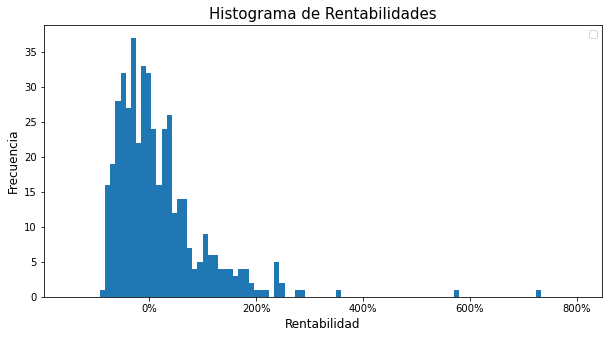

count    454.000000
mean       0.169846
std        0.842502
min       -0.879247
25%       -0.382811
50%       -0.021237
75%        0.459918
max        7.277593
dtype: float64


In [14]:
def to_percent(x, position):
    return f"{100 * x:.0f}%"
formatter = mtick.FuncFormatter(to_percent)

plt.figure(figsize=(10, 5))
plt.hist(indiv_ret, bins=np.linspace(-1.5, 8, 100))
plt.title("Histograma de Rentabilidades", fontsize=15)
plt.xlabel("Rentabilidad", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()
plt.show()
print(pd.Series(indiv_ret).describe())

<AxesSubplot:ylabel='Rentabilidad'>

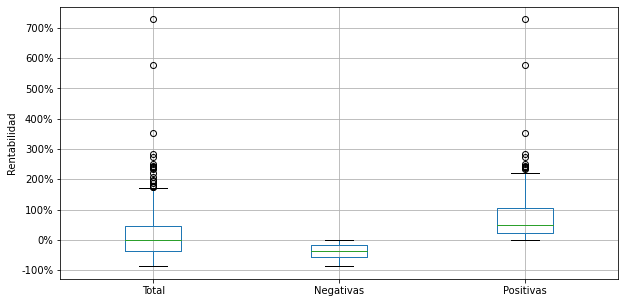

In [175]:
orig = pd.Series(indiv_ret)
neg = pd.Series(indiv_ret)[pd.Series(indiv_ret) < 0]
pos = pd.Series(indiv_ret)[pd.Series(indiv_ret) > 0]

plt.figure(figsize=(10, 5))
plt.ylabel("Rentabilidad")
plt.gca().yaxis.set_major_formatter(formatter)
indiv_info = pd.concat([orig, neg, pos], axis=1)
indiv_info.columns = ['Total', 'Negativas', 'Positivas']
indiv_info.boxplot()

In [147]:
# Demostración funcionamiento en AMD --> Media de 169,47% de rentabilidad (20 + 1 iteraciones)
pd.options.mode.chained_assignment = None  # default='warn'

# Simulamos para cada una de los tickets
initial_capital = 10000000
cap_per_stock_FLT = 10000000
for ticker in ["FLT"] * 20:
    final_cap_FLT, FLT_hist = train_test_agent(ticker = ticker, initial_cash = cap_per_stock_FLT, initial_stock = 0, n_episodes = 100,
                            start_date_train = datetime(2012,1,1), end_date_train = datetime(2017,1,1), 
                            start_date_test = datetime(2017,1,1), end_date_test = datetime(2022,10,30),
                            window = 3, window_lt = 252)
    print(f"Ticker: {ticker}\nRentabilidad: {round((final_cap_FLT / cap_per_stock_FLT - 1) * 100, 2)}%\n")

pd.options.mode.chained_assignment = "warn"  # default='warn'

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 64.33%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 84.22%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 76.98%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 251.33%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 151.67%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 94.5%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 151.57%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 21.77%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 11.39%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 151.25%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 75.55%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 150.97%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 513.93%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 327.51%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 181.71%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 182.2%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 306.69%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 225.12%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 213.2%

[*********************100%***********************]  1 of 1 completed
Entrenando para FLT...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: FLT
Rentabilidad: 115.56%



In [156]:
FLT_data = yf.download("FLT", start = datetime(2017,4,24), end = datetime(2022,10,30))["Adj Close"]
FLT_data_10M = FLT_data / FLT_data.iloc[0] * 10000000

[*********************100%***********************]  1 of 1 completed


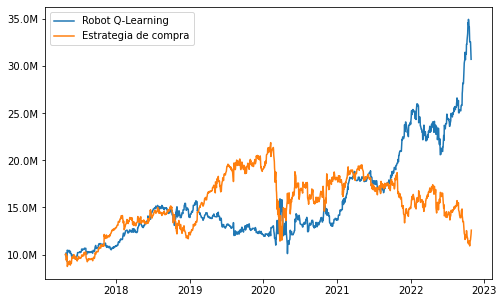

In [163]:
# Ejemplo rentabilidad robot 207.42%
def to_millions(x, pos):
    return f'{x*1e-6:.1f}M'
formatter = mtick.FuncFormatter(to_millions)


plt.figure(figsize=(8, 5))
plt.plot(FLT_hist.Capital, label = "Robot Q-Learning")
plt.plot(FLT_data_10M, label = "Estrategia de compra")
plt.legend(loc = 'upper left')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [109]:
# Demostración funcionamiento en AMD --> Media de 641,94% de rentabilidad (20 + 1 iteraciones)
pd.options.mode.chained_assignment = None  # default='warn'

# Simulamos para cada una de los tickets
initial_capital = 10000000
cap_per_stock_AMD = 10000000
for ticker in ["AMD"] * 20:
    final_cap_AMD, AMD_hist = train_test_agent(ticker = ticker, initial_cash = cap_per_stock_AMD, initial_stock = 0, n_episodes = 100,
                            start_date_train = datetime(2012,1,1), end_date_train = datetime(2017,1,1), 
                            start_date_test = datetime(2017,1,1), end_date_test = datetime(2022,10,30),
                            window = 3, window_lt = 252)
    print(f"Ticker: {ticker}\nRentabilidad: {round((final_cap_AMD / cap_per_stock_AMD - 1) * 100, 2)}%\n")

pd.options.mode.chained_assignment = "warn"  # default='warn'

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 117.89%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMD
Rentabilidad: 1229.72%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 747.12%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMD
Rentabilidad: 461.0%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 824.44%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 791.52%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMD
Rentabilidad: 274.17%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 1199.09%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 417.23%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 36.61%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 405.91%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 681.28%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMD
Rentabilidad: 475.6%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 158.7%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 1274.31%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 416.03%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


[*********************100%***********************]  1 of 1 completed
Ticker: AMD
Rentabilidad: 277.44%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.28it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 1450.23%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 274.9%

[*********************100%***********************]  1 of 1 completed
Entrenando para AMD...



100%|█████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]

[*********************100%***********************]  1 of 1 completed


Ticker: AMD
Rentabilidad: 197.51%



In [144]:
AMD_data = yf.download("AMD", start = datetime(2017,4,24), end = datetime(2022,10,30))["Adj Close"]
AMD_data_10M = AMD_data / AMD_data.iloc[0] * 10000000

[*********************100%***********************]  1 of 1 completed


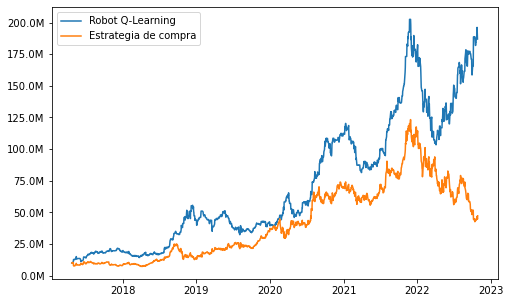

In [145]:
# Ejemplo rentabilidad robot 1770.13%
def to_millions(x, pos):
    return f'{x*1e-6:.1f}M'
formatter = mtick.FuncFormatter(to_millions)


plt.figure(figsize=(8, 5))
plt.plot(AMD_hist.Capital, label = "Robot Q-Learning")
plt.plot(AMD_data_10M, label = "Estrategia de compra")
plt.legend(loc = 'upper left')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

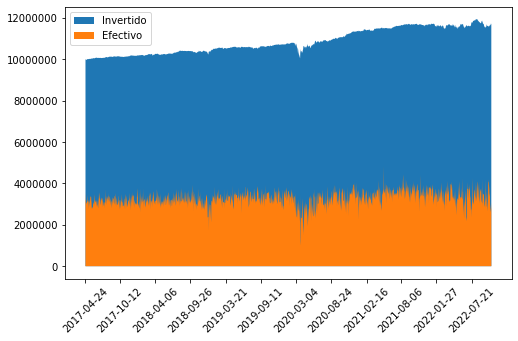

In [86]:
plt.figure(figsize=(8, 5))
plt.fill_between(sum_hist_invested.index, sum_history.Capital, label="Invertido")
plt.fill_between(sum_history.index, sum_history.Capital - sum_hist_invested, label="Efectivo")
plt.legend(loc = 'upper left')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.f'))
plt.xticks(sum_history.index[::120], rotation = 45)
plt.show()

In [15]:
total_return = (sum_history.Capital.iloc[-1]/sum_history.Capital.iloc[0] - 1)
print(f"Total Return: {round(total_return * 100, 2)}%")
total_capital = sum_history.Capital
daily_return = total_capital.pct_change()
annualized_return = ((total_capital.iloc[-1] / total_capital.iloc[0]) ** (252 / len(total_capital)) - 1)
print("Annualized Return: {:.2f}%".format(annualized_return * 100))
volatility = daily_return.std() * np.sqrt(252)
print("Volatility: {:.2f}%".format(volatility * 100))
cumulative_returns = (1 + daily_return).cumprod()
cumulative_returns.iloc[0] = 1
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()
print("Maximum Drawdown: {:.2f}%".format(max_drawdown*100))

daily_risk_free = pd.read_csv("Datos/F-F_Research_Data_Factors_daily-3.csv", index_col = 0)
daily_risk_free.index = pd.to_datetime(daily_risk_free.index, format='%Y%m%d')
daily_risk_free = daily_risk_free[daily_risk_free.index >= pd.to_datetime("2017-01-01")].RF
daily_risk_free = daily_risk_free[daily_risk_free.index <= pd.to_datetime("2022-10-31")]
daily_risk_free = daily_risk_free / 100
daily_excess_returns = (daily_return - daily_risk_free).dropna()
mean_daily_excess_returns = daily_excess_returns.mean()
daily_volatility_er = daily_excess_returns.std()
daily_sharpe_ratio = mean_daily_excess_returns / daily_volatility_er
sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

Total Return: 16.98%
Annualized Return: 2.88%
Volatility: 4.00%
Maximum Drawdown: -7.05%
Sharpe Ratio: 0.47
